## Imports

In [46]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve

## Functions

In [107]:
def create_seq(dataset, target, features):
    
    sequence_len = 48
    X = []
    y = []

    for i in range(sequence_len + 120, len(dataset) - sequence_len):
        X_temp = dataset[features].iloc[i - sequence_len - 120 : i - 120].values
        y_temp = dataset[target].iloc[i]
    
        X.append(X_temp)
        y.append(y_temp)

    X = np.array(X)
    y = np.array(y)
    
    return X, y


def lstm_model(dataset, feature_cols, target_col, train_size, sequence_len=48, 
               lstm_units1=50, lstm_units2=50, dropout1=0.2, dropout2=0.2, dense_units=25, epochs=30, batch_size=32):

    
    def build_lstm_model(sequence_length, feature_count):
        model = Sequential([
            LSTM(lstm_units1, activation='relu', return_sequences=True, input_shape=(sequence_length, feature_count)),
            Dropout(dropout1),
            LSTM(lstm_units2, activation='relu', return_sequences=False),
            Dropout(dropout2),
            Dense(dense_units),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def create_sequences(features, target, sequence_len):
        X, y = [], []
        for i in range(sequence_len + 120, len(features)):
            X.append(features[i - sequence_len - 120 : i - 120]) # use past week of data
            y.append(target[i])
        return np.array(X), np.array(y)
    
    X_data = dataset[feature_cols].values
    y_data = dataset[target_col].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_scaled = scaler.fit_transform(X_data)

    X, y = create_sequences(features_scaled, y_data, sequence_len)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define the LSTM model
    feature_count = len(feature_cols)
    model = build_lstm_model(sequence_len, feature_count)

    # Fit the model
    print('Fitting the model:')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping], verbose=1)

    return model, history, X_train, X_test, y_train, y_test


def gridsearch(X, y, sequence_length, feature_count):
    
    
    def build_tuned_model(hp):
        model = Sequential([
            LSTM(hp.Int('units1', min_value=32, max_value=128, step=16), activation='relu', return_sequences=True, input_shape=(sequence_length, feature_count)),
            Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)),
            LSTM(hp.Int('units2', min_value=32, max_value=128, step=16), activation='relu', return_sequences=False),
            Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),
            Dense(hp.Int('dense_units', 10, 50, step=10)),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # We consuct hyperparameter tuning to find optimal params
    tuner = RandomSearch(
        build_tuned_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print('Optimal units in LSTM_1 layers: ', best_hps.get('units1'))
    print('Optimal units in LSTM_2 layers: ', best_hps.get('units2'))
    print('Optimal dropout_1 rate: ', best_hps.get('dropout1'))
    print('Optimal dropout_2 rate: ', best_hps.get('dropout2'))
    print('Optimal dense layer units: ', best_hps.get('dense_units'))
    

def visualize_lstm(history):
    
    # Visualize Training loss graph
    print('Loss Graph:')
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Visualize Validation loss graph
    print('Loss Graph:')
    plt.figure(figsize=(12,6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    
def auc_plot(y_test, y_pred):
    
    # Compute AUC
    auc = roc_auc_score(y_test, y_pred)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

## Data

In [97]:
# Load dataset
root = '../data/'
path = 'ml_features.csv'
df = pd.read_csv(os.path.join(root,path))
df["date"] = pd.to_datetime(df["date"])
df.set_index('date', inplace=True)
df.dropna(inplace=True)
df

,rt_prices,da_prices,load_realized,load_forecast,capacity,temperature,humidity,precipitation,wind_speed,wind_direction,...,spike_60,past_spikes_30,past_spikes_45,past_spikes_60,past_da_load_error,past_da_price_error,is_weekend,hour,month,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,128.915833,128.46,2499.016667,2330.0,2717.500000,-12.952500,62.0,0.0,7.127636,315.00010,...,0,2.0,1.0,0.0,8.657710e+05,18265.332557,0,1,1,0
2018-01-01 02:00:00,131.331667,124.63,2394.441667,2238.0,2713.333333,-12.752501,61.0,0.0,8.209263,307.87503,...,0,2.0,1.0,0.0,9.323887e+05,18909.514557,0,2,1,0
2018-01-01 03:00:00,136.922500,125.83,2331.325000,2188.0,2650.000000,-12.602500,60.0,0.0,9.832680,293.74950,...,0,3.0,1.0,0.0,9.865578e+05,19498.749824,0,3,1,0
2018-01-01 04:00:00,125.941667,123.65,2308.791667,2177.0,2674.166667,-12.952500,62.0,0.0,9.028754,293.49857,...,0,4.0,1.0,0.0,1.030178e+06,20912.901655,0,4,1,0
2018-01-01 05:00:00,122.996667,127.28,2321.550000,2198.0,2695.000000,-12.702500,62.0,0.0,9.085988,303.69010,...,0,4.0,1.0,0.0,1.063819e+06,21640.850085,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,32.165833,36.94,2468.963167,2536.0,3000.000000,5.347500,53.0,0.0,16.862455,286.11350,...,0,1.0,1.0,1.0,2.378046e+05,4643.051269,1,19,12,0
2023-12-31 20:00:00,33.734167,35.68,2358.665175,2448.0,3000.000000,5.397500,51.0,0.0,13.104197,285.94547,...,0,0.0,0.0,0.0,2.293922e+05,955.965258,1,20,12,0
2023-12-31 21:00:00,33.896667,34.62,2255.596967,2358.0,3000.000000,5.047500,53.0,0.0,10.315115,299.24872,...,0,0.0,0.0,0.0,2.295808e+05,916.772151,1,21,12,0


### Threshold: 30

In [108]:
# Build dataset for threshold 30
target_col_30 = 'spike_30'
feature_cols_30 = ['past_spikes_30', 'hdd', 
                   'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                   'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']

df_30 = df.copy()
df_30 = df_30[[target_col_30] + feature_cols_30]
df_30

,spike_30,past_spikes_30,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,
2018-01-01 01:00:00,0,2.0,31.252500,0.0,8.657710e+05,18265.332557,1,1,0,0,0.857406
2018-01-01 02:00:00,1,2.0,31.052501,0.0,9.323887e+05,18909.514557,1,2,0,0,0.824816
2018-01-01 03:00:00,1,3.0,30.902500,0.0,9.865578e+05,19498.749824,1,3,0,0,0.825660
2018-01-01 04:00:00,0,4.0,31.252500,0.0,1.030178e+06,20912.901655,1,4,0,0,0.814085
2018-01-01 05:00:00,1,4.0,31.002500,0.0,1.063819e+06,21640.850085,1,5,0,0,0.815584
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0,1.0,12.952500,0.0,2.378046e+05,4643.051269,12,19,1,0,0.845333
2023-12-31 20:00:00,0,0.0,12.902500,0.0,2.293922e+05,955.965258,12,20,1,0,0.816000
2023-12-31 21:00:00,0,0.0,13.252500,0.0,2.295808e+05,916.772151,12,21,1,0,0.786000


In [109]:
# Create a shifted dataset so that we forecast 48h-ahead
# This is needed for the gridsearch
X_30, y_30 = create_seq(df_30, target_col_30, feature_cols_30)

In [57]:
# Perform gridsearch to optimize parameters
shutil.rmtree("untitled_project", ignore_errors=True)
opt_param_30 = gridsearch(X=X_30,
                          y=y_30, 
                          sequence_length=48, 
                          feature_count=len(feature_cols_30))

Trial 10 Complete [00h 03m 51s]
val_loss: 33.6668701171875

Best val_loss So Far: 0.43320828676223755
Total elapsed time: 00h 41m 32s
Optimal units in LSTM_1 layers:  96
Optimal units in LSTM_2 layers:  48
Optimal dropout_1 rate:  0.2
Optimal dropout_2 rate:  0.5
Optimal dense layer units:  40


In [110]:
# Build LSTM model (train 2018-2022, test 2023)
train_size = 43385
model_30, history_30, X_train_30, X_test_30, y_train_30, y_test_30 = lstm_model(dataset=df_30,
                                                                                feature_cols=feature_cols_30,
                                                                                target_col=target_col_30,
                                                                                train_size=train_size, 
                                                                                sequence_len=48,
                                                                                lstm_units1=96,
                                                                                lstm_units2=48,
                                                                                dropout1=0.2,
                                                                                dropout2=0.5,
                                                                                dense_units=40,
                                                                                epochs=30, 
                                                                                batch_size=32)

Fitting the model:
Epoch 1/30


C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1356/1356 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.9107 - loss: 0.3156 - val_accuracy: 0.9327 - val_loss: 0.2469
Epoch 2/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9162 - loss: 2.2635 - val_accuracy: 0.9327 - val_loss: 0.2464
Epoch 3/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9162 - loss: 0.2795 - val_accuracy: 0.9327 - val_loss: 0.2442
Epoch 4/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9159 - loss: 0.2771 - val_accuracy: 0.9327 - val_loss: 0.2483
Epoch 5/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9157 - loss: 0.2750 - val_accuracy: 0.9327 - val_loss: 0.2483
Epoch 6/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9172 - loss: 0.2725 - val_accuracy: 0.9327 - val_loss: 0.2485
Epoch 7/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9167 - loss: 0.2736 - val_accuracy: 0.9327 - val_loss: 0.2482
Epoch 8/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9155 - loss: 0.27

Loss Graph:


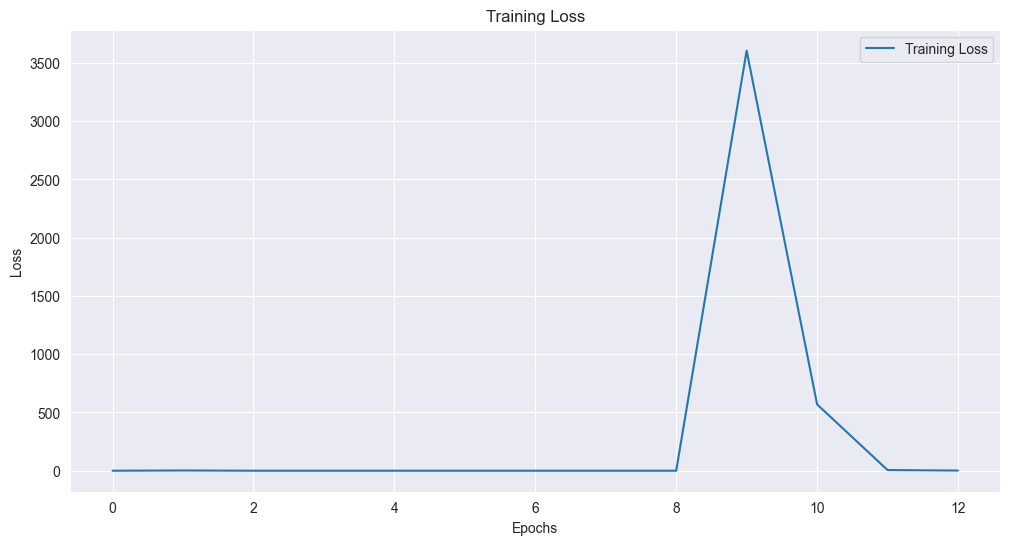

Loss Graph:


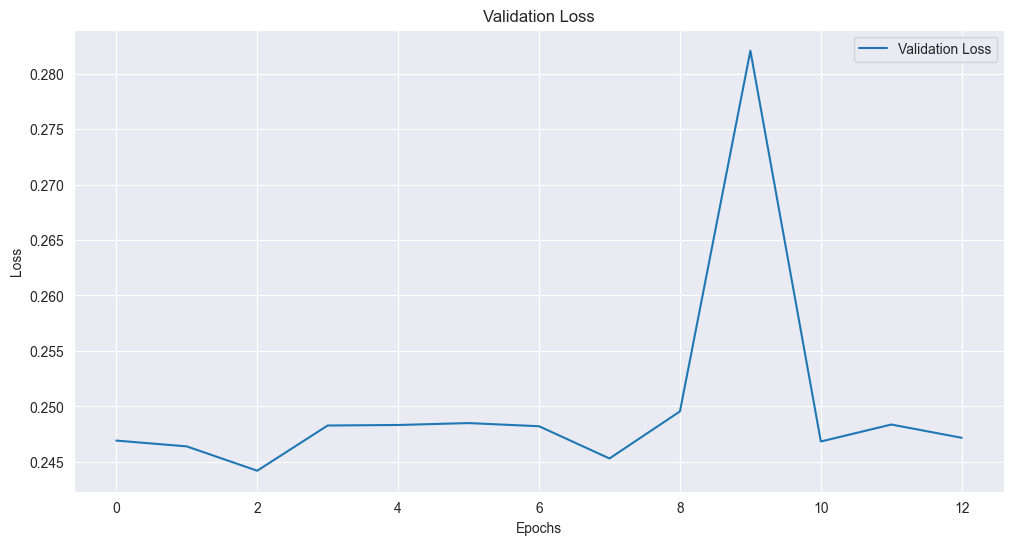

In [111]:
# Display loss graphs
visualize_lstm(history_30)

In [112]:
# Compute predicted spike probabilities
y_pred_30 = model_30.predict(X_test_30).ravel()
y_pred_30

267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


array([0.04468127, 0.03704764, 0.03313928, ..., 0.11462915, 0.10271796,
       0.08923173], dtype=float32)

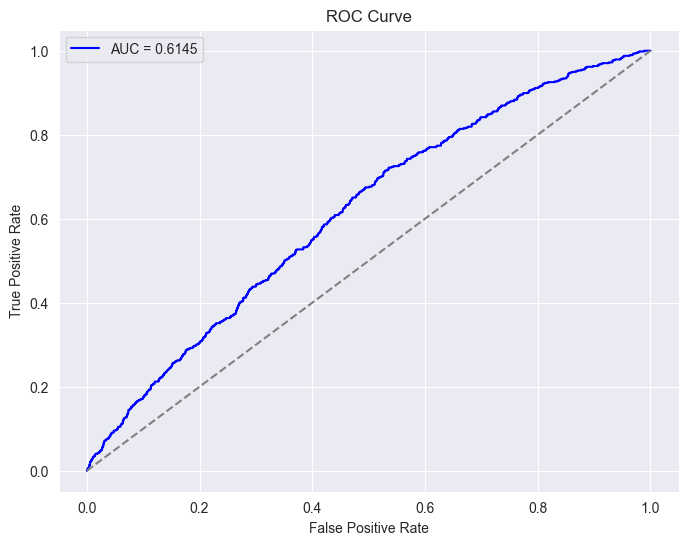

In [113]:
# Display AUC plot
auc_plot(y_test_30, y_pred_30)

In [116]:
# Compute average log-likelihood
p_30 = np.clip(y_pred_30, 1e-9, 1 - 1e-9)

log_lik_30 = y_test_30 * np.log(p_30) + (1 - y_test_30) * np.log(1 - p_30)
avg_log_likelihood_30 = np.mean(log_lik_30)

print("Average Log-Likelihood:", avg_log_likelihood_30)

Average Log-Likelihood: -0.24420018976789287


### Threshold: 45

In [118]:
# Build dataset for threshold 45
target_col_45 = 'spike_45'
feature_cols_45 = ['past_spikes_45', 'hdd', 
                   'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                   'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']

df_45 = df.copy()
df_45 = df_45[[target_col_45] + feature_cols_45]
df_45

,spike_45,past_spikes_45,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,
2018-01-01 01:00:00,0,1.0,31.252500,0.0,8.657710e+05,18265.332557,1,1,0,0,0.857406
2018-01-01 02:00:00,0,1.0,31.052501,0.0,9.323887e+05,18909.514557,1,2,0,0,0.824816
2018-01-01 03:00:00,0,1.0,30.902500,0.0,9.865578e+05,19498.749824,1,3,0,0,0.825660
2018-01-01 04:00:00,0,1.0,31.252500,0.0,1.030178e+06,20912.901655,1,4,0,0,0.814085
2018-01-01 05:00:00,0,1.0,31.002500,0.0,1.063819e+06,21640.850085,1,5,0,0,0.815584
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0,1.0,12.952500,0.0,2.378046e+05,4643.051269,12,19,1,0,0.845333
2023-12-31 20:00:00,0,0.0,12.902500,0.0,2.293922e+05,955.965258,12,20,1,0,0.816000
2023-12-31 21:00:00,0,0.0,13.252500,0.0,2.295808e+05,916.772151,12,21,1,0,0.786000


In [119]:
# Create a shifted dataset so that we forecast 48h-ahead
# This is needed for the gridsearch
X_45, y_45 = create_seq(df_45, target_col_45, feature_cols_45)

In [120]:
# Perform gridsearch to optimize parameters
shutil.rmtree("untitled_project", ignore_errors=True)
opt_param_45 = gridsearch(X=X_45,
                          y=y_45, 
                          sequence_length=48, 
                          feature_count=len(feature_cols_45))

Trial 10 Complete [00h 04m 22s]
val_loss: 1.9102452993392944

Best val_loss So Far: 0.21820701658725739
Total elapsed time: 00h 48m 59s
Optimal units in LSTM_1 layers:  96
Optimal units in LSTM_2 layers:  64
Optimal dropout_1 rate:  0.4
Optimal dropout_2 rate:  0.5
Optimal dense layer units:  50


In [121]:
# Build LSTM model (train 2018-2022, test 2023)
train_size = 43385
model_45, history_45, X_train_45, X_test_45, y_train_45, y_test_45 = lstm_model(dataset=df_45,
                                                                                feature_cols=feature_cols_45,
                                                                                target_col=target_col_45,
                                                                                train_size=train_size, 
                                                                                sequence_len=48,
                                                                                lstm_units1=96,
                                                                                lstm_units2=64,
                                                                                dropout1=0.4,
                                                                                dropout2=0.5,
                                                                                dense_units=50,
                                                                                epochs=30, 
                                                                                batch_size=32)

Fitting the model:
Epoch 1/30


C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.9424 - loss: 0.2403 - val_accuracy: 0.9540 - val_loss: 0.1833
Epoch 2/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9444 - loss: 1.7680 - val_accuracy: 0.9540 - val_loss: 0.1862
Epoch 3/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9431 - loss: 0.2094 - val_accuracy: 0.9540 - val_loss: 0.1849
Epoch 4/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9435 - loss: 0.2439 - val_accuracy: 0.9540 - val_loss: 0.1833
Epoch 5/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9442 - loss: 0.2021 - val_accuracy: 0.9540 - val_loss: 0.1833
Epoch 6/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9441 - loss: 0.2022 - val_accuracy: 0.9540 - val_loss: 0.1842
Epoch 7/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9460 - loss: 0.1975 - val_accuracy: 0.9540 - val_loss: 0.1869
Epoch 8/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9452 - loss: 0.19

Loss Graph:


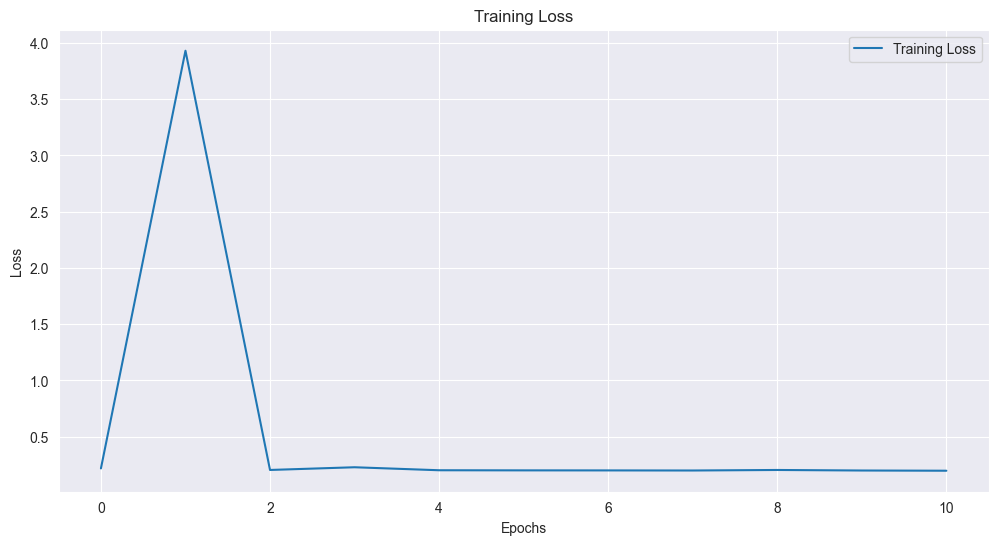

Loss Graph:


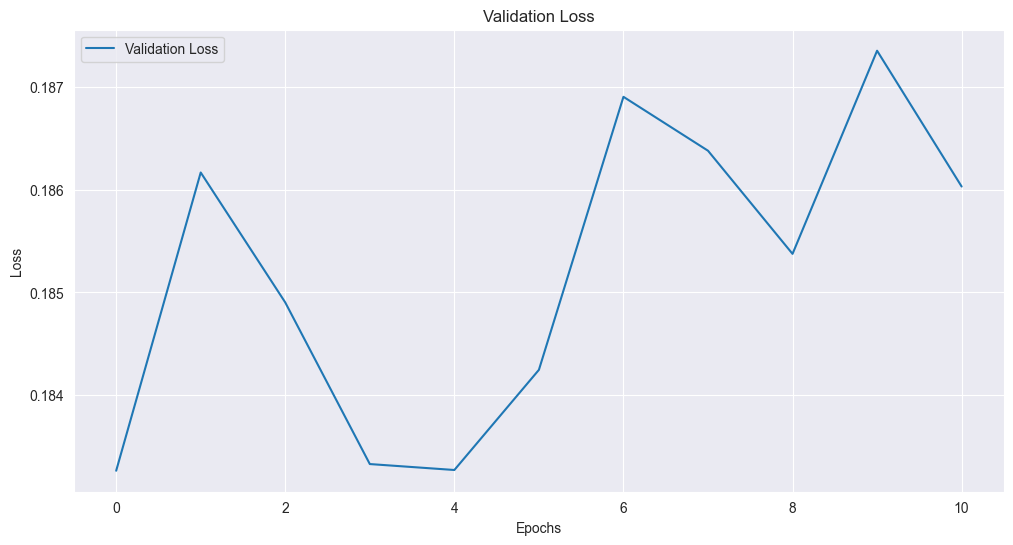

In [122]:
# Display loss graphs
visualize_lstm(history_45)

In [123]:
# Compute predicted spike probabilities
y_pred_45 = model_45.predict(X_test_45).ravel()
y_pred_45

267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


array([0.02936757, 0.02539675, 0.02425683, ..., 0.07452513, 0.06969438,
       0.06420326], dtype=float32)

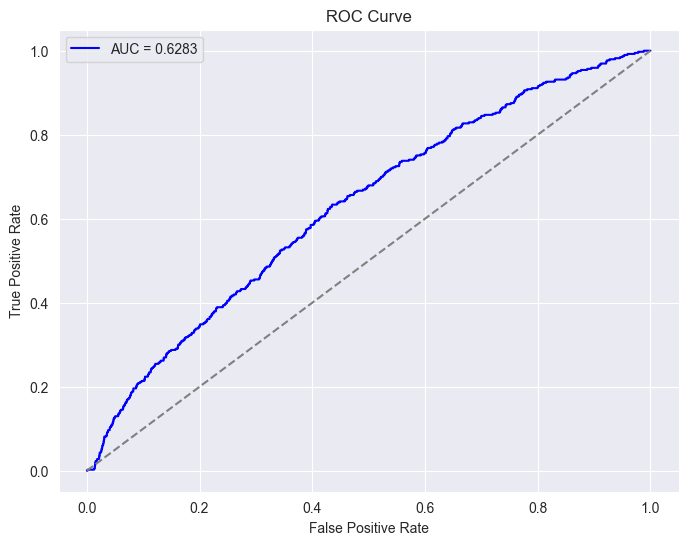

In [124]:
# Display AUC plot
auc_plot(y_test_45, y_pred_45)

In [125]:
# Compute average log-likelihood
p_45 = np.clip(y_pred_45, 1e-9, 1 - 1e-9)

log_lik_45 = y_test_45 * np.log(p_45) + (1 - y_test_45) * np.log(1 - p_45)
avg_log_likelihood_45 = np.mean(log_lik_45)

print("Average Log-Likelihood:", avg_log_likelihood_45)

Average Log-Likelihood: -0.1832607378601369


### Threshold: 60

In [126]:
# Build dataset for threshold 30
target_col_60 = 'spike_60'
feature_cols_60 = ['past_spikes_60', 'hdd', 
                   'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                   'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']

df_60 = df.copy()
df_60 = df_60[[target_col_60] + feature_cols_60]
df_60

,spike_60,past_spikes_60,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,
2018-01-01 01:00:00,0,0.0,31.252500,0.0,8.657710e+05,18265.332557,1,1,0,0,0.857406
2018-01-01 02:00:00,0,0.0,31.052501,0.0,9.323887e+05,18909.514557,1,2,0,0,0.824816
2018-01-01 03:00:00,0,0.0,30.902500,0.0,9.865578e+05,19498.749824,1,3,0,0,0.825660
2018-01-01 04:00:00,0,0.0,31.252500,0.0,1.030178e+06,20912.901655,1,4,0,0,0.814085
2018-01-01 05:00:00,0,0.0,31.002500,0.0,1.063819e+06,21640.850085,1,5,0,0,0.815584
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0,1.0,12.952500,0.0,2.378046e+05,4643.051269,12,19,1,0,0.845333
2023-12-31 20:00:00,0,0.0,12.902500,0.0,2.293922e+05,955.965258,12,20,1,0,0.816000
2023-12-31 21:00:00,0,0.0,13.252500,0.0,2.295808e+05,916.772151,12,21,1,0,0.786000


In [127]:
# Create a shifted dataset so that we forecast 48h-ahead
# This is needed for the gridsearch
X_60, y_60 = create_seq(df_60, target_col_60, feature_cols_60)

In [128]:
# Perform gridsearch to optimize parameters
shutil.rmtree("untitled_project", ignore_errors=True)
opt_param_60 = gridsearch(X=X_60,
                          y=y_60, 
                          sequence_length=48, 
                          feature_count=len(feature_cols_60))

Trial 10 Complete [00h 06m 21s]
val_loss: 2.548788547515869

Best val_loss So Far: 0.18055811524391174
Total elapsed time: 00h 53m 13s
Optimal units in LSTM_1 layers:  128
Optimal units in LSTM_2 layers:  48
Optimal dropout_1 rate:  0.1
Optimal dropout_2 rate:  0.30000000000000004
Optimal dense layer units:  50


In [129]:
# Build LSTM model (train 2018-2022, test 2023)
train_size = 43385
model_60, history_60, X_train_60, X_test_60, y_train_60, y_test_60 = lstm_model(dataset=df_60,
                                                                                feature_cols=feature_cols_60,
                                                                                target_col=target_col_60,
                                                                                train_size=train_size, 
                                                                                sequence_len=48,
                                                                                lstm_units1=128,
                                                                                lstm_units2=48,
                                                                                dropout1=0.1,
                                                                                dropout2=0.3,
                                                                                dense_units=50,
                                                                                epochs=30, 
                                                                                batch_size=32)

Fitting the model:
Epoch 1/30


C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1356/1356 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.9568 - loss: 14.3856 - val_accuracy: 0.9651 - val_loss: 0.1523
Epoch 2/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.9615 - loss: 0.1657 - val_accuracy: 0.9651 - val_loss: 0.1501
Epoch 3/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9612 - loss: 0.2855 - val_accuracy: 0.9651 - val_loss: 0.1474
Epoch 4/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9608 - loss: 0.1564 - val_accuracy: 0.9651 - val_loss: 0.1481
Epoch 5/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9609 - loss: 0.1562 - val_accuracy: 0.9651 - val_loss: 0.1479
Epoch 6/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9604 - loss: 0.1573 - val_accuracy: 0.9651 - val_loss: 0.1482
Epoch 7/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9614 - loss: 0.1544 - val_accuracy: 0.9651 - val_loss: 0.1502
Epoch 8/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9602 - loss: 0.1

Loss Graph:


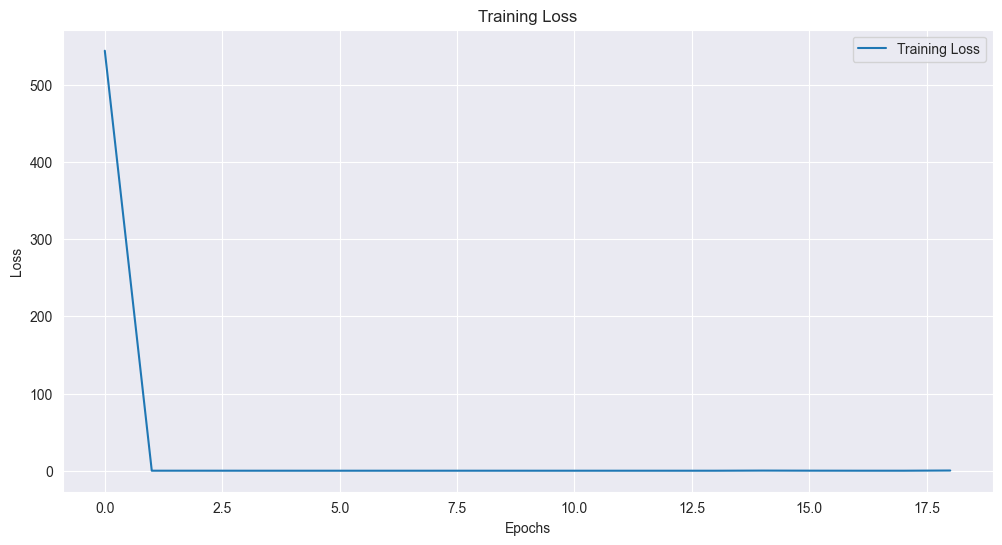

Loss Graph:


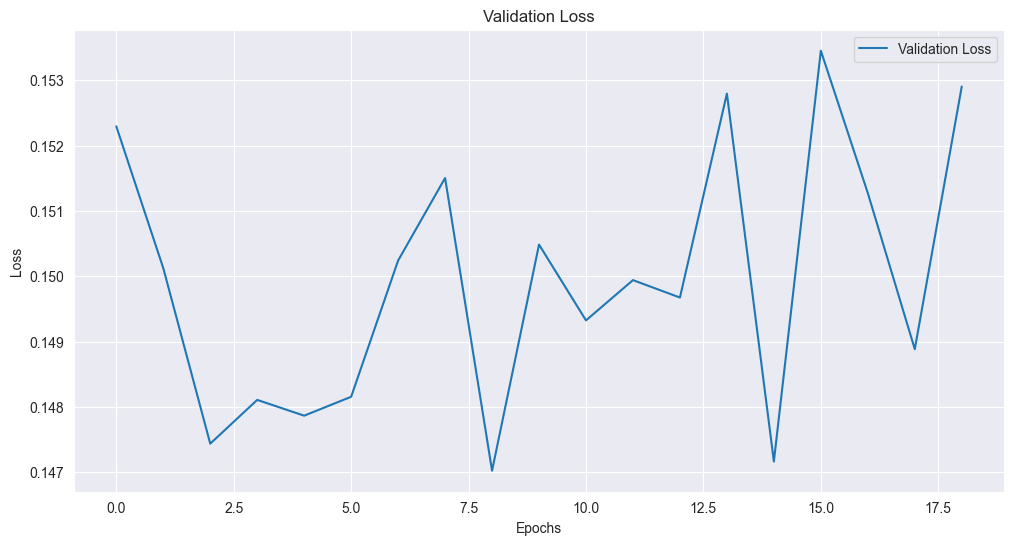

In [130]:
# Display loss graphs
visualize_lstm(history_60)

In [131]:
# Compute predicted spike probabilities
y_pred_60 = model_60.predict(X_test_60).ravel()
y_pred_60

267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


array([0.03740869, 0.034645  , 0.03353087, ..., 0.04955155, 0.04345233,
       0.03747446], dtype=float32)

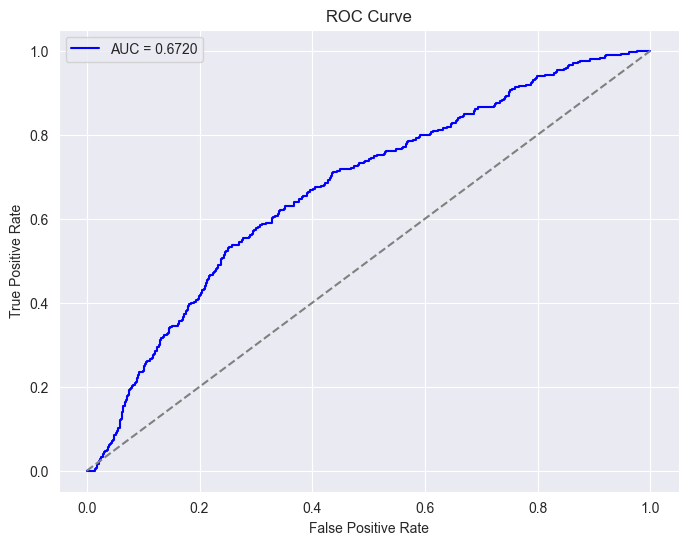

In [132]:
# Display AUC plot
auc_plot(y_test_60, y_pred_60)

In [133]:
# Compute average log-likelihood
p_60 = np.clip(y_pred_60, 1e-9, 1 - 1e-9)

log_lik_60 = y_test_60 * np.log(p_60) + (1 - y_test_60) * np.log(1 - p_60)
avg_log_likelihood_60 = np.mean(log_lik_60)

print("Average Log-Likelihood:", avg_log_likelihood_60)

Average Log-Likelihood: -0.14702420287514034
